In [1]:
import sys
import re
import glob
import spacy
import statistics
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pprint as pp
from IPython.display import Markdown, display
# from liwc import Liwc
from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups
from spacy.lang.en import English
from matplotlib import rcParams
from collections import Counter

import scipy.cluster.hierarchy as sch

from gensim.models import KeyedVectors # to load word embedding model
from scipy.spatial.distance import cosine

warnings.filterwarnings('ignore')
nlp = English()
tokenizer = nlp.Defaults.create_tokenizer(nlp)

In [2]:
liwc_tentative = ["pretty", "confused", "hesitant", "hopefully", "confusing", "hoping",
    "doubt", "doubting", "hope", "confuse", "hoped", "luck", "lucky", "any",
    "questions", "kind of", "probably", "something", "or", "anything",
    "may", "some", "try", "perhaps", "if", "possible", "bet", "guess",
    "anyhow", "most", "quite", "might", "sort", "somewhat", "assuming",
    "supposed", "seem", "somebody", "maybe", "someone", "assume", "trying",
    "lot", "question", "sometimes", "option", "dunno", "approximately",
    "sorta", "generally", "options", "possibility", "kinda", "overall",
    "seems", "wondering", "somewhere", "sometime", "assumption",
    "potentially", "possibly", "optional", "optionally", "mostly", "almost",
    "depending", "often", "seemed", "potential", "temporarily",
    "occasionally", "wonder", "someone's", "lots", "opinion", "apparently",
    "somehow", "somebody's", "suppose", "barely", "usually", "random",
    "vary", "anywhere", "puzzle", "practically", "fairly", "wondered",
    "depends", "appears", "unknown", "assumed", "probablyâ", "unlikely",
    "mainly", "something's", "vaguely", "sorts", "theory", "chance",
    "typically", "possibleâ", "confusion", "virtually", "anyone",
    "appearing", "depend", "anybody", "likely", "unclear", "supposing",
    "possibilities", "appear", "alot", "border", "assumes", "guessing",
    "hardly", "anytime", "temporary", "randomly", "lotta", "hypothetical",
    "contingent", "someday", "undecided", "hypothesize", "blurred",
    "variable", "theoretically", "partly", "borderline", "variables",
    "feasible", "confusions", "somethingo", "mystery", "questioning",
    "assumptions", "possibilites", "betting", "indirectly", "supposedly",
    "varies", "vague", "temporally", "indirect", "puzzling"]

In [3]:
liwc_tentative.sort()
liwc_tentative
model = KeyedVectors.load_word2vec_format('models/numberbatch-en-17.06.w2v', binary=True)

In [4]:
def get_vectors_for_tokens(tokens, model):
    vector_list = []
    new_token_list = []
    for token in tokens:
        if token in model:
            vector_list.append(model[token])
            new_token_list.append(token)
        else :
            print(token, "not in model")
    return (vector_list, new_token_list) # word discarded if not found in numberbatch model

In [5]:
def cosine_similarity(tokens, model, threshold=0.0):
    sim_matrix = []
    vectors, pruned_tokens = get_vectors_for_tokens(tokens, model)
    for ind, ref_vector in enumerate(vectors):
        sim_row = []
        for vector in vectors:
            cosine_similarity_calc = 1-cosine(ref_vector, vector)
            if cosine_similarity_calc > threshold :
                cosine_similarity = cosine_similarity_calc
            else :
                cosine_similarity = 0.0
            # Note: cosine similarity is the mathematically sound construct : it follows triangle inequality.
            sim_row.append(cosine_similarity)
        sim_matrix.append(sim_row)
    sim_mat_numpy = np.array(sim_matrix).T    
    df = pd.DataFrame(sim_mat_numpy)
    df.insert(0, "words", pruned_tokens, True)
    return df

In [6]:
def plot_similarity_cluster(tokens, model, normalize=False, method='weighted', metric='cityblock'):
    df = cosine_similarity(tokens, model, threshold = 0.00)
    similarity_matrix = df[df.columns[1:]].to_numpy()
    pruned_tokens = df['words']
    colormap = 'viridis_r'
    if normalize :
        col_min = np.min(similarity_matrix)
        col_max = np.max(similarity_matrix)
    else :
        col_min = 0
        col_max = 1
    
    cm = sns.clustermap(data=similarity_matrix, vmin=col_min, vmax=col_max, figsize=[24,24], 
                        method='weighted', metric=metric,
                        cbar_kws=None, row_cluster=True, col_cluster=True,
                        #metric="correlation", method="single", 
                        cmap=colormap, 
                        yticklabels=pruned_tokens, 
                        xticklabels=pruned_tokens,
                        # cbar=False, 
                        standard_scale=None)
    cm.ax_row_dendrogram.set_visible(True)
    cm.ax_col_dendrogram.set_visible(False)
    cm.cax.set_visible(False)
    plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, 
             rotation_mode="anchor", ha='left')
    plt.setp(cm.ax_heatmap.xaxis.get_majorticklabels(), rotation=45,
             rotation_mode='anchor', ha='right')
    plt.savefig('plots/liwc_tentative_clusters_threshold'+metric+'.pdf', dpi=300, bbox_inches='tight')

kind of not in model
possibilites not in model
possibleâ not in model
probablyâ not in model
somethingo not in model


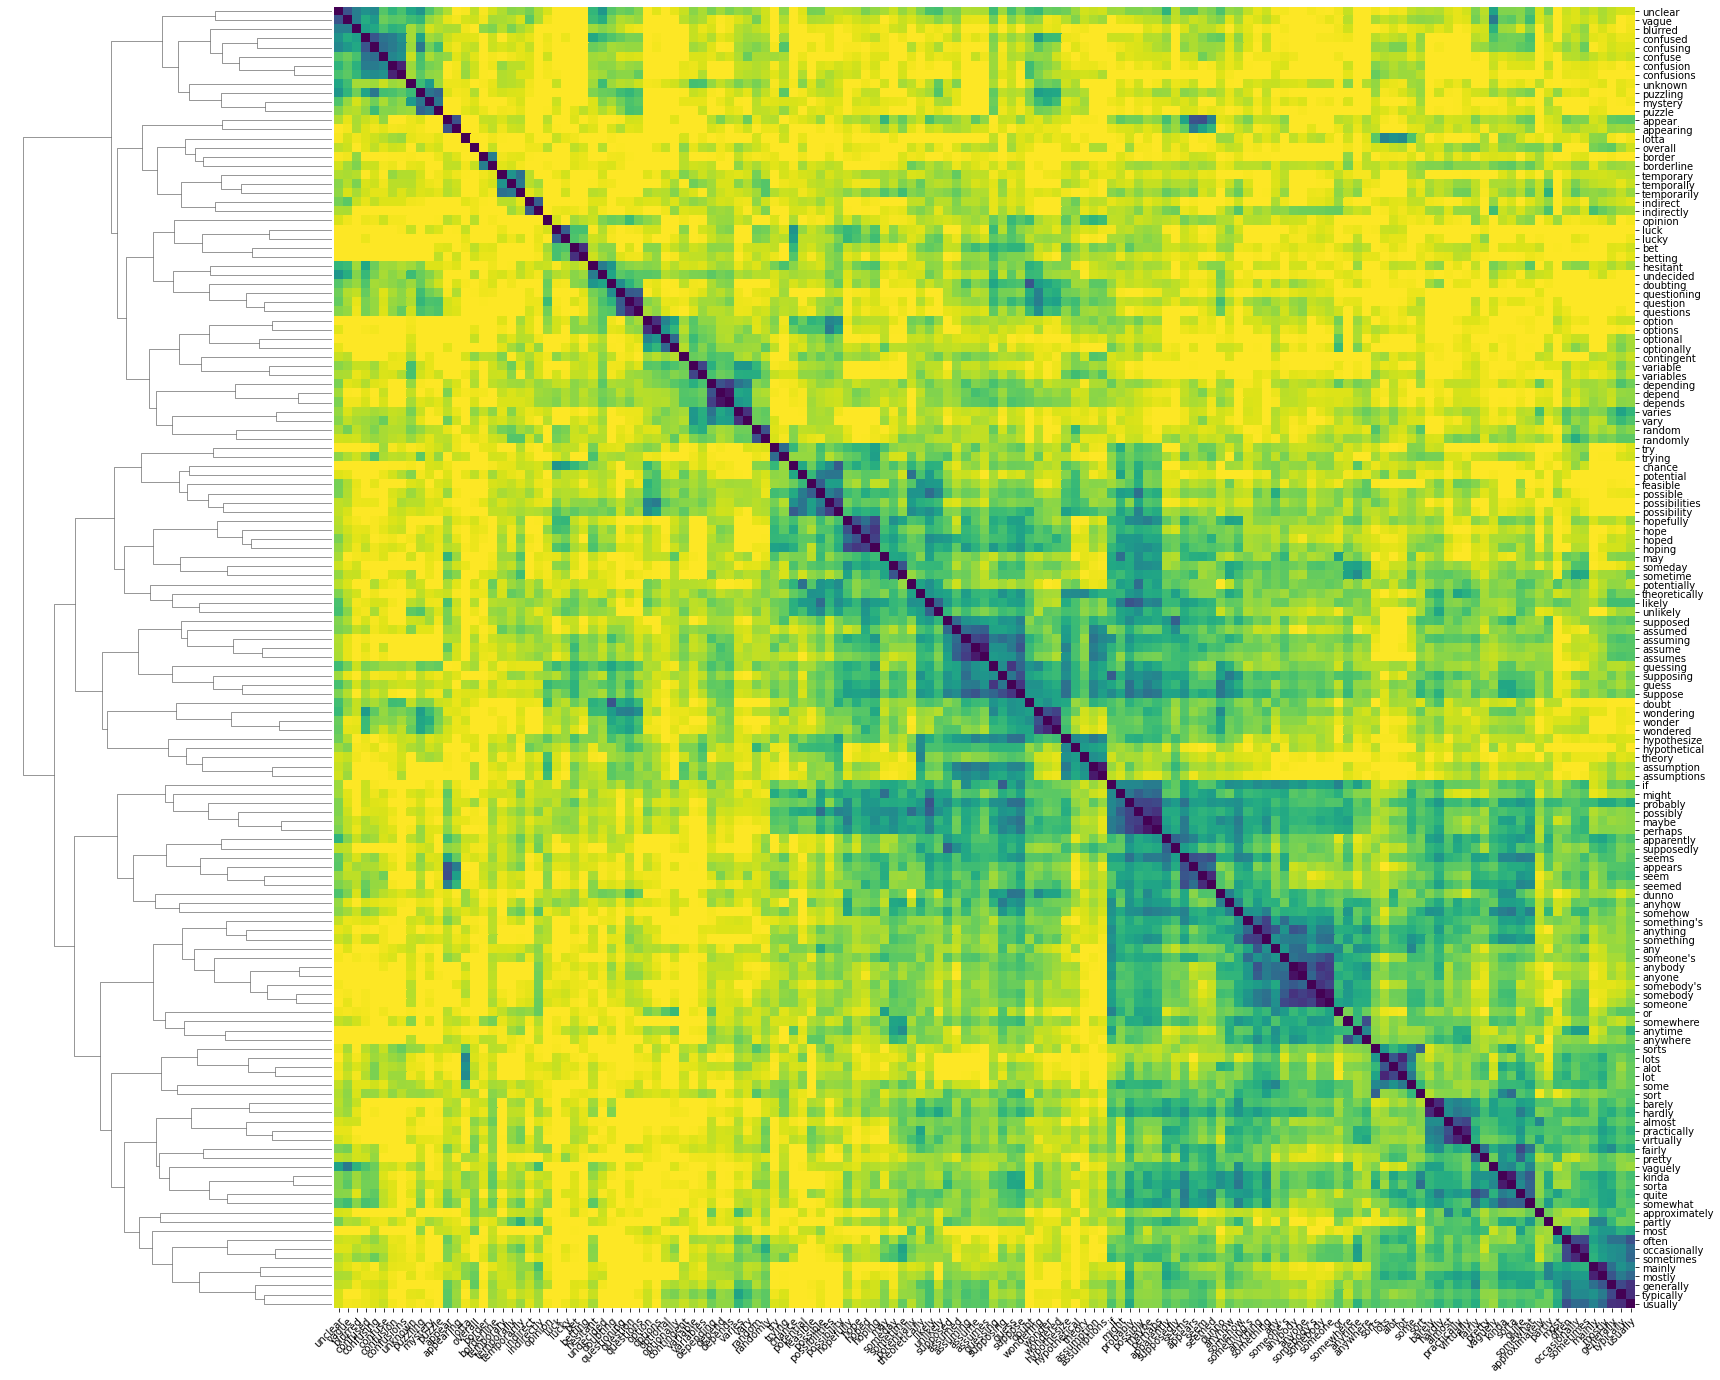

In [7]:
plot_similarity_cluster(liwc_tentative, model, normalize=False)

In [8]:
# plot_similarity_cluster(liwc_tentative, model, metric='euclidean', normalize=False)